In [ ]:
'''
import numpy as np
import nnfs
from nnfs.datasets import sine_data, spiral_data

nnfs.init()

URL = 'https://nnfs.io/datasets/fashion_mnist_images.zip'
FILE = 'fashion_mnist_images.zip'
FOLDER = 'fashion_mnist_images'

import os 
import urllib
import urllib.request

if not os.path.isfile(FILE):
    print(f'Donloading{URL} and saving as {FILE}...')
    urllib.request.urlretrieve(URL, FILE)

from zipfile import ZipFile
print("Unzipping images...")
with ZipFile(FILE) as zip_images:
    zip_images.extractall(FOLDER)
    '''


In [11]:
import numpy as np
import cv2
import os

def load_mnist_dataset(dataset, path):

    #scan all the directories and create a list of labels
    labels = os.listdir(os.path.join(path,dataset))

    X = []
    y = []

    for label in labels:
        for file in os.listdir(os.path.join(path, dataset, label)):
            #read the image
            image = cv2.imread(os.path.join(path, dataset, label, file), cv2.IMREAD_UNCHANGED)
            X.append(image)
            y.append(label)

    return np.array(X), np.array(y).astype('uint8')

def create_data_mnist(path):
    X,y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)

    return X,y, X_test, y_test
    


In [12]:
#datapreprocessing

#create dataset
X,y ,X_test, y_test = create_data_mnist('fashion_mnist_images')

#scale features
X= (X.astype(np.float32)-127.5) / 127.5
X_test= (X_test.astype(np.float32)-127.5) / 127.5

print(X.min(), X.max())

-1.0 1.0


In [14]:
X = X.reshape(X.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)



In [15]:
keys = np.array( range (X.shape[ 0 ]))
print (keys[: 10 ])

[0 1 2 3 4 5 6 7 8 9]


In [16]:
import nnfs
nnfs.init()
np.random.shuffle(keys)
print (keys[: 10 ])

[ 3048 19563 58303  8870 40228 31488 21860 56864   845 25770]


In [18]:
X = X[keys]
y = y[keys]

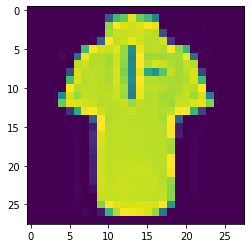

In [21]:
import matplotlib.pyplot as plt
plt.imshow((X[4].reshape(28,28)))
plt.show()

In [ ]:
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

X,y = spiral_data(samples =100, classes = 3)

EPOCHS = 10
BATCH_SIZE = 128

#calculate number of steps
steps = X.shape[0] // BATCH_SIZE

#dividing round down. if there are some remaining data
#but not a full batch, this won't include it
#add 1 to include the remaining samples in 1 more step

if steps * BATCH_SIZE < X.shape[0]:
    steps += 1

for epoch in range(EPOCHS):
    for step in range(steps):
        batch_x = X[step*BATCH_SIZE:(step + 1) * BATCH_SIZE]
        batch_y = y[step*BATCH_SIZE:(step +1) * BATCH_SIZE]
        


In [ ]:


class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1 = 0, weight_regularizer_l2 = 0, bias_regularizer_l1 = 0, bias_regularizer_l2 = 0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        #set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2= bias_regularizer_l2

    def forward(self, inputs):
        #remember input values
        self.inputs = inputs
        #calculate output value from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    #backward pass

    def backward(self, dvalues):
        #gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        #Gradient on regularization
        #L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        #L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2* self.weight_regularizer_l2* self.weights

        #L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.weights < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1


        #L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        #Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

#Dropout

class Layer_Dropout:
    #init
    def __init__(self, rate):
        #store rate, we inter ti as for example for dropout of 0.1 we need siccess rate of 0.9
        self.rate = 1 - rate
    #forward pass
    def forward(self, inputs, training):
        #save input values
        self.inputs = inputs

        #if not in the training_mode -return values
        if not training:
            self.output = inputs.copy()
            return

        #Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate, size = inputs.shape )/ self.rate

        #Apply mask to output values
        self.output = inputs * self.binary_mask

        #backward pass
    def backward(self, dvalues):
        #Gradient on values
        self.dinputs = dvalues * self.binary_mask


class Activation_ReLU:
    #forward pass
    def forward(self, inputs):
        #remember input values
        self.inputs = inputs
        #calculate output values from inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        #since we need to modify original variable,
        #let's make a copy of values first
        self.dinputs = dvalues.copy()

        #Zero gradient where input values were negative
        self.dinputs[self.dinputs <= 0] = 0

    
    #calculate predictions for outputs
    def predictions(self,outputs):
        return outputs
#Softmax activation

class Activation_Softmax:
    def forward(self, inputs):
        #remember input values
        self.inputs = inputs

        #get nunnormalizer probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims = True))
        
        #normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis =1, keepdims = True )
        self.output = probabilities
    
    def backward(self, dvalues):
        #create unintialized array
        self.dinputs = np.empty_like(dvalues)

        #enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            #flatten the output array
            single_output = single_output.reshape(-1,1)
            
            #calculate jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            
            #calculate sample-wise gradient
            #and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
    
    def predictions(self, outputs):
        return np.argmax(outputs, axis = 1)

#Sigmoid activation
class Activation_Sigmoid:

    #forward pass
    def forward(self, inputs):
        #save input and calculate / save output of the sigmoid function

        self.inputs = inputs
        self.output = 1/ (1 + np.exp(-inputs))

        #bakcward pass
    def backward(self, dvalues):
        #derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1- self.output) * self.output

    #calculate prediction for outputs
    def predictions(self, outputs):
        return(outputs > 0.5) * 1

#Linear activation

class Activation_Linear:

    #forward pass
    def forward(self, inputs):
        #just remember values
        self.inputs = inputs
        self.output = inputs

    #Backward pass
    def backward(self, dvalues):
        #derivative is 1,1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()

    #Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs

class Optimizer_SGD:
    #initialize optimizer -set settings,
    #learning rate of 1 is default for this optimizer

    def __init__(self, learning_rate = 1., decay = 0., momentum = 0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    #Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay + self.iterations))

    def update_params(self, layer):
        if self.momentum:

            #if layer does not contain momentum arrays. create them
            #filled with zeros

            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                #if there is no momentum array for weights
                #the array does not exist for biases yet either
                layer.bias_momentums = np.zeros_like(layer.biases)

                #build weight updates with momentum - take previous
                #updates multiplied by retain factor and update with current gradient
                weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
                layer.weight_momentums = weight_updates

                #build bias update
                bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
                layer.bias_momentums = bias_updates
            #vanilla SGD updates

            else:
                weight_updates = -self.current_learning_rate * layer.dweights
                bias_updates = -self.current_learning_rate * layer.dbiases

            #udpate weights and biases using either vanilla or momentum updates

            layer.weights += weight_updates
            layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1


#Adagrad Optimizer
class Optimizer_Adagrad:
    #initialize optimizer - set settings:

    def __init__(self, learning_rate = 1., decay = 0, epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):
        # if layer does not contain cache arrays
        #create them filled with zeros

        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        #update cache with squared current gradients
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2

        # Vanilla SGD parameter udpate + normalizatoin
        #with square rooted cache
        layer.weights += self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache)+ self.epsilon)

        #call once after any parameter updates

    def post_update_params(self):
        self.iterations += 1


#RMSprop optimizer

class Optimizer_RMSprop:

    #initialize optimizer - set setiings

    def __init__(self, learning_rate = 0.001, decay = 0, epsilon = 1e-7, rho = 0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):

        #if layer does not contain cache arrays
        #create them filled with zeros

        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        #update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases ** 2


        #Vanilla SGD Parameter update + normalization with square rooted cache
        layer.weights += - self.current_learning_rate * layer.dweights (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.bias += self.current_learning_rate * layer.dbiases(np.sqrt(layer.bias_cache) + self.epsilon)

        #call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


class Optimizer_Adam:

    #Initialize optimizer - set setiings

    def __init__(self, learning_rate = 0.001, decay = 0, epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay =decay
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    
    #call once before any paramter updates
    def pre_udpate_params(self):
        if self.decay: 
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    #Update parameters
    def update_params(self, layer):

        #if layer does not conatin cache arrays
        #create them filled with zeros

        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache= np.zeros_like(layer.biases)

            #update momentum with current gradients
            layer.weights_momentums = self.beta_1 * layer.weight_momentums (1- self.beta_1)* layer.dweights
            layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

            weight_momentums_corrected = layer.weight_momentums / (1- self.beta_1 ** (self.iterations + 1))
            bias_momentums_corrected = layer.bias_momentums / (1- self.beta_1 ** (self.iterations + 1))
            #update cache with squared current gradients
            layer.weight_cache = self.beta_2 * layer.weight_cache + (1- self.beta_2)* layer.dweights ** 2
            layer.bias_cache = self.beta_2 * layer.bias_cache + (1- self.beta_2) * layer.dbiases ** 2

            #get corrected cache
            weight_cache_corrected = layer.weights_cache / (1- self.beta_2 ** (self.iterations + 1))
            bias_cache_corrected = layer.bias_cache / (1- self.beta_2 ** (self.iterations + 1))

            #Vanilla SGD parameter update + normalization with square rooted cache

            layer.weight += -self.current_learning_rate * weight_momentums_corrected/ (np.sqrt(weight_cache_corrected) + self.epsilon)
            layer.biases += self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

class Loss:

    #regularization loss calculation
    def regularization_loss(self):
        #0 by default
        regularization_loss = 0

        #calculate regularization loss
        #iterate all trainable layers

        for layer in self.trainable_layers:
            
            #L1 regularization weight 
            #calculate only when factor greater than 0

            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

            #L2 regularization weights
            if layer.weight_regularizer_l2 >0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

            #L1 regularization biases
            #calcualte only factor greater than 0

            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.dbiases))

            #L2 regularizer -biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases* layer.biases)

        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
        
        #calculates the data and regularization losses
        #given model output and gorund truth values

    def calculate(self, output, y, * , include_regularization = False):
        #calculate sample losses
        sample_losses = self.forward(output, y)

        #calculate mean loss
        data_loss = np.mean(sample_losses)

        #add accumulated sum of losses and sample count
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        #if not just data loss return it
        if not include_regularization:
            return data_loss

        #Return the data and regularization losses
        return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization = False):

        #calculate man loss
        data_loss = self.calculate_accumulated_sum / self.accumulated_count

        if not include_regularization:
            return data_loss

        return data_loss, self.regularization_loss()
    
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0


class Loss_CategoricalCrossentropy(Loss):

    #forward pass
    def forward(self, y_pred, y_true):
        #Number of samples in a batch
        samples= len(y_pred)

        #clip data to prevent division by 0
        #clip both sides to not drag mean towards and value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1- 1e-7)

        #probabilites for taget values only if categorical variables
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples), y_true
            ]
        #mask values only for one hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis = 1
            )

        #losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):

        #Number of samples
        samples = len(dvalues)

        #Number of labels in every sample
        #We'll use the first sample to count them
        labels = len(dvalues[0])

        #if labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        #calculate gradient
        self.dinputs = -y_true / dvalues

        #Normalize gradient
        self.dinputs = self.dinputs / samples

    #Softmax classifier- combined softmax activation
    #and cross entropy loss for faster backward step

class Activation_Softmax_Loss_CatergoricalCrossentropy():
    #backward pass

    def backawrd(self, dvalues, y_true):
        #number of samples

        samples = len(dvalues)

        #if labels are one hot encoded turn them into discrete values
        if len(y_true.shape) ==2:
            y_true = np.argmax(y_true, axis = 1)

        #copy so we can safely modify()
        self.dinputs = dvalues.copy()

        #calculate gradient
        self.dinputs[range(samples), y_true] -=1
        #Normalize gradient
        self.dinputs = self.dinputs / samples

class Loss_BinaryCrossentropy(Loss):

    def forward(self, y_pred, y_true):

        #clip data to prevent division by 0
        #clip both sides to not drage man towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1- 1e-7)

        #calculate sample wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1- y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis = 1)

        #Return losses
        return sample_losses

    def backward(self, dvalues, y_true):
        #number of samples
        samples = len(dvalues)

        #Number of outputs in every sample
        #We'll use the first sample to count them
        outputs = len(dvalues[0])

        #clip data to prevent division by 0
        #clip both sides to not drage mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1-1e-7)

        #calculate gradient
        self.dinputs = -(y_true / clipped_dvalues - ( 1- y_true) / (1 - clipped_dvalues)) / outputs
        
        #normalize gradient
        self.dinputs =self.dinputs / samples

class Loss_MeanSquaredError(Loss):

    #forward pass
    def forward(self, y_pred, y_true):
        #calculate loss
        sample_losses = np.mean((y_true - y_pred)** 2, axis = 1)
        return sample_losses

    #backward pass
    def backward(self, dvalues, y_true):
        #number of samples
        samples = len(dvalues)

        #number of outputs in every sample
        #we'll use the first sample to count htem
        outputs = len(dvalues[0])

        #Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        #Normalize Gradient
        self.dinputs = self.dinputs / samples

#Mean Absolute Error Loss

class Loss_MeanAbsoluteError(Loss):

    def forward(self, y_pred, y_true):
        #calculate_loss

        sample_losses = np.mean(np.abs(y_true - y_pred),axis = 1)
        return sample_losses

    #backward pass
    def backward(self, dvalues, y_true):
        #number of samples
        samples = len(dvalues)
        
        #number of outputs in every samples
        #we'll use the first sample to count them
        outputs = len(dvalues[0])

        #calculate gradient
        self.dinputs = np.sign(y_true, dvalues) / outputs
        #Normalize graident
        self.dinputs = self.dinputs /samples
class Accuracy:
    #calculates an accuracy
    #given predictions and ground truth values

    def calculate(self, predictions, y):
        #get comparison results
        comparisons= self.compare(predictions, y)

        #calculate an accuracy 
        accuracy = np.mean(comparisons)

        #add accumulated sum of matching values and sample count
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)

        #return accuracy
        return accuracy
    
    def calculate_accumulated(self):
        #calculate an accuracy
        accuracy = self.accumulated_sum / self.accumulated_count

        return accuracy
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0




class Accuracy_Categorical(Accuracy):
    def init(self, y):
        pass
    #compares predictions to the ground truth values

    def compare(self, predictions, y):
        if len(y.shape) == 2:
            y = np.argmax(y, axis =1 )
        return predictions == y

class Accuracy_Regression(Accuracy):
    def __init__(self):
        self.precision = None

    #calculates precision value
    #based on passed in the ground truth values
    def init(self, y , reinit = False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250

    def compare(self, predictions,y ):
        return np.absolut(predictions - y) < self.precision


class Layer_Input:

    #forward pass
    def forward (self, inputs):
        self.output = inputs

class Model:

    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)
        
    def set(self, * , loss, optimizer):
        self.loss = loss
        self.optimizer = optimizer
    
    def train(self, X, y, *, epochs = 1, print_every = 1, validation_data = None, batch_size = None):
        #initialize accuracy object
        self.accuracy.innit(y)

        #default value if batch size is not being set
        train_steps = 1

        if validation_data is not None:
            validation_steps = 1

            #for better readability
            X_val, y_val = validation_data

            # calculate number of steps
            if batch_size is not None:
                train_steps = len(X) // batch_size 

                #dividing rounds down. If there are some remaining data but not a full batch, this won't include it
                #add 1 to include this not full batch_size
                if train_steps * batch_size < len(X):
                    train_steps += 1

                if validation_data is not None:
                    validation_steps = len(X_val) // batch_size
                    #Dividing rounds down. if there are some remaining data but not full batch, this won't include it add 1 to include this not full batch
                    if validation_steps * batch_size < len(X_val): validation_steps += 1
            
            for epoch in range(1, epochs+1):
                #print epoch number
                print(f'epoch:{epoch}')

                #reset accumulated values in loss and accuracy objects
                self.loss.new_pass()
                self.accuracy.new_pass()

                #iterate over steps
                for step in range(train_steps):
                    if batch_size is None:
                        batch_X = X
                        batch_y = y
                
                #otherwise slize a batch
                else:
                    batch_X = X[step*batch_size:(step + 1) * batch_size]
                    batch_y = y[step*batch_size:(step + 1) * batch_size]

                #perform the forward pass
                output = self.forward(batch_X, training = True)

                #calculate loss
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization = True)
                loss = data_loss + regularization_loss

                #get predictions and calcualte an accuracy
                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)


                #perform a backward pass
                self.backward(output, batch_y)

                #optimize(update parameters)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()

                #print a summary
                if not step % print_every or step == train_steps -1:
                    print ( f'step: {step} , ' +
                            f'acc: {accuracy :.3f} , ' +
                            f'loss: {loss :.3f} (' +
                            f'data_loss: {data_loss :.3f} , ' +
                            f'reg_loss: {regularization_loss :.3f} ), ' +
                            f'lr: {self.optimizer.current_learning_rate} ' )
                
                if validation_data is not None:

                    #reset accumulated values in loss and accuracy objects
                    self.loss.new_pass()
                    self.accuracy.new_pass()

                    #iterate over steps
                    for step in range(validation_steps):

                        #if batch size is not set
                        #train using one step and full dataset
                        if batch_size is None:
                            batch_X = X_val
                            batch_y = y_val

                        #otherwise slice a batch
                        else:
                            batch_X = X_val[ step * batch_size:(step+1)*batch_size]
                            batch_y = y_val[step * batch_size:(step+1) *batch_size]

                        #perform the forward pass
                        output = self.forward(batch_X, training = False)

                        #calculate the loss
                        self.loss.calculate(output, batch_y)

                        #Get predictions and calculate an accuracy
                        predictions = self.output_later_activation_predictions(output)
                        self.accuracy.calculate(predictions, batch_y)

                    #get and print validation loss and accuracy
                    validation_loss = self.loss.calculate_accumulated()
                    validation_accuracy = self.accuracy.calculate_accumulated()

                    # Print a summary
                    print (f'validation, ' +
                    f'acc: {validation_accuracy :.3f} , ' +
                    f'loss: {validation_loss :.3f} ' )





            




    def finalize(self):
        self.input_layer = Layer_Input()

        layer_count = len(self.layers)

        for i in range(layer_count):

            # If it's the first layer,
            # the previous layer object is the input layer
            if i == 0 :
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i + 1 ]
            # All layers except for the first and the last
            elif i < layer_count - 1 :
                self.layers[i].prev = self.layers[i - 1 ]
                self.layers[i].next = self.layers[i + 1 ]
            # The last layer - the next object is the loss
            else :
                self.layers[i].prev = self.layers[i - 1 ]
                self.layers[i].next = self.loss

            # If layer contains an attribute called "weights",
            # it's a trainable layer -
            # add it to the list of trainable layers
            # We don't need to check for biases -
            # checking for weights is enough
            if hasattr (self.layers[i], 'weights' ):
                self.trainable_layers.append(self.layers[i])

    def forward(self, X):
        self.input_layer.forward(X)

        for layer in self.layers:
            layer.forward(layer.prev.output)
        
        return layer.output


In [ ]:
X, y = sine_data()
model = Model()
# Add layers
model.add(Layer_Dense( 1 , 64 ))
model.add(Activation_ReLU())
model.add(Layer_Dense( 64 , 64 ))
model.add(Activation_ReLU())
model.add(Layer_Dense( 64 , 1 ))
model.add(Activation_Linear())

model.set(
    loss = Loss_MeanSquaredError,
    optimizer = Optimizer_Adam(learning_rate = 0.005, decay = 1e-3)
)
model.finalize()

model.train(X,y, epochs = 1000, print_every = 100)